# U.S. Bureau of Labor Statistics (BLS)

This example requests data on the number of job openings and hires in the construction industry from the BLS API.

In [1]:
# Preliminaries (Python 2.7)
import requests
import json
import config # file called config.py with my API key
import pandas as pd

import math

%matplotlib inline

### Simple example

Get recent civilian labor force participation rate data from the BLS API v1.

This example can be used to get the most recent values for a single series using the BLS version 1 API (which does not require registration) and the BLS series id of interest. 

In [2]:
# BLS API v1 url
url = 'https://api.bls.gov/publicAPI/v1/timeseries/data/'

# BLS series id for the civilian labor force participation rate
series = 'LNS11300000'

#### Get the data

In [ ]:
# get the data returned by the url and series id
r = requests.get('{}{}'.format(url, series))

In [56]:
# Generate pandas dataframe from the data returned
df = pd.DataFrame(r.json()['Results']['series'][0]['data'])

# Convert the period and year columns to datetime (YYYY-MM-DD)
df['date'] = pd.to_datetime(df['period'] + ' ' + df['year'])

# Set the date as the index and reverse dataframe order
df = df.set_index('date').iloc[::-1]

# Identify the values column as numbers
df['value'] = df['value'].astype(float)

# Show the latest value:
df.iloc[-1:,]['value']

date
2017-05-01    62.7
Name: value, dtype: float64

#### Compare latest value to mean

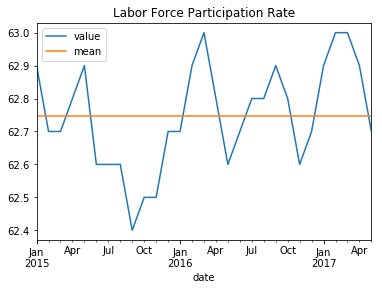

In [60]:
# Add a column with the period mean
df = df.assign(mean = df['value'].mean())

# Simple line plot of the result
df.plot(title='Labor Force Participation Rate')

### Slightly more complex example -- multiple series
Use the BLS API v2 (which requires [registration](https://data.bls.gov/registrationEngine/)) to request more than one series at the same time. The version 2 API has a higher daily query limit, allows more years and series to be returned in each query, and allows some additional options such as requesting data in percent change rather than level. See [difference between v1 and v2](https://www.bls.gov/developers/api_faqs.htm#register1).

In [2]:
# The url for BLS API v2
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# API key in config.py which contains: bls_key = 'key'
key = '?registrationkey={}'.format(config.bls_key)

# Series stored as a list
series_list = ['LNS14000003', 'LNS14000006']

#### Post request for the data

This time we need to include some additional information with the request for data. Previously we used a *get* request, but if we want to submit data to be processed by the API we need to use a *post* request. See: [What is the difference between POST and GET?](https://stackoverflow.com/questions/3477333/what-is-the-difference-between-post-and-get) for more information.  

First, we will tell the API to provide data in json format by including a content-type entity header.

In [3]:
# Specify json as content type to return
headers = {'Content-type': 'application/json'}

# Submit the list of series as data
data = json.dumps({"seriesid":series_list})

# Post request for the data
p = requests.post('{}{}'.format(url, key), headers=headers, data=data).json()

# Blank pandas dataframe to be filled later
df = pd.DataFrame()

#### Loop through series and convert to pandas format

Since the API returns data in a uniform way, a loop can be used to apply formatting or other changes to all series in the returned json data. In the example below, I format both series as pandas dataframes with a datetime index and the values converted to floats. 

In [23]:
# Empty dictionary. Each entry will be one series
d = {}

# Loop through the series and convert to datetime indexed float values
for series in p['Results']['series']:
    s = series['seriesID']  # Short name, 's', for series ID
    d[s] = pd.DataFrame(series['data'])
    d[s]['date'] = pd.to_datetime(d[s]['period'] + ' ' + d[s]['year'])
    d[s] = d[s].set_index('date')['value'].astype(float)

# Combine the individual dictionary entries into one dataframe
df = pd.concat(d, axis=1).iloc[::-1]

# Show last five rows
df.tail()

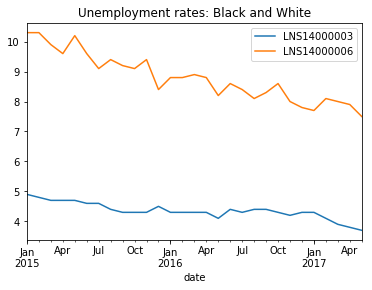

In [26]:
# Simple line plot of the data
df.plot(title='Unemployment rates: Black and White')

### Multiple series, multiple decades

Even the version 2 API places limits on how many years worth of data can be returned in each request. For queries that require a longer time series, more than one request may be needed. 

This third example retrieves data on construction sector job openings and hires since 2000. 

In [82]:
# Include the start and end year here
date_range = (2000, 2017)

# Divide the date range into BLS-API-friendly length requests
req_no = int(math.ceil((date_range[1] - date_range[0]) / 10.0))
dates = []
for i in range(0,req_no):
    d1 = str(date_range[0]+i*10)
    d2 = str(date_range[0]+i*10+9)
    dates.append((d1,d2))
dates[-1] = (dates[-1][0], str(date_range[1]))

dates

[('2000', '2009'), ('2010', '2017')]

#### API and series information

In [83]:
# URL, key, and headers same as above
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(config.bls_key)
headers = {'Content-type': 'application/json'}

# This time, store the series into a dictionary with description
series_dict = {'JTS23000000JOL': 'Construction Job Openings (Level, Thousands)',
               'JTS23000000HIL': 'Construction Hires (Level, Thousands)'}

df = pd.DataFrame()  # blank pandas dataframe to be filled later

#### Make requests for each date range in dates

In [87]:
for start, end in dates: 
    
    # The data sent in the post request now includes a start and end year
    data = json.dumps({"seriesid":series_dict.keys(), "startyear":start, "endyear":end})
    p = requests.post('{}{}'.format(url, key), headers=headers, data=data).json()
    d = {} # New dictionary to be filled with data
    for series in p['Results']['series']:
        s = series['seriesID']  # Shorten name to 's'
        
        # Add dictionary entry with series and reverse series order
        d[s] = pd.DataFrame(series['data']).iloc[::-1]
        if len(series['data']) > 0:  # This if/else is to allow for series of different lengths
            
            # Convert BLS API dates to readable format (YYYY-MM-DD)
            d[s]['date'] = pd.to_datetime(d[s]['period'] + ' ' + d[s]['year'])
            
            # Keep only date and series values
            d[s] = d[s].set_index('date')['value'].astype(float)
            
            # Rename and identify values as floating point numbers
            d[s] = d[s].rename(series_dict[s])
        else:  # If blank, leave as a blank pandas series
            d[s]['date'] = d[s]['value'] = pd.Series()
            d[s] = d[s]['value'].rename(series_dict[s])
            
    # Combine the dataframes for each range of years into one by appending        
    df = df.append(pd.concat([d[k] for k in series_dict.keys()], axis=1))

View the results

In [89]:
df.tail()

,"Construction Job Openings (Level, Thousands)","Construction Hires (Level, Thousands)"
date,,
2016-12-01,140.0,400.0
2017-01-01,142.0,387.0
2017-02-01,181.0,367.0
2017-03-01,161.0,372.0
2017-04-01,203.0,378.0
